In [1]:
import os
import keras
from keras.layers import BatchNormalization
from tensorflow.keras.applications.densenet import DenseNet121
from keras import regularizers
from sklearn.metrics import confusion_matrix
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import datasets, layers, models, regularizers
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, GlobalAveragePooling2D
from keras.models import Sequential
from tensorflow import keras
import tensorflow as tf
import sys
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau, Callback
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from keras.metrics import Precision, Recall
import pandas as pd
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

sys.modules['Image'] = Image 

In [2]:
target_size = 64,64
Batch_size = 32
learning_rate = 0.00001
epochs = 400
SEED = 12

In [3]:
datagen = ImageDataGenerator(
    validation_split=0.2
)


# Create the original train_generator object using the flow_from_directory function

train_generator = datagen.flow_from_directory(
    'C:/Users/TomHu/OneDrive/Desktop/Final Year project/Train',
    target_size=target_size,
    batch_size=Batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=SEED
)

validation_generator = datagen.flow_from_directory(
   'C:/Users/TomHu/OneDrive/Desktop/Final Year project/Train',
    target_size=target_size,
    batch_size=Batch_size,
    class_mode='categorical',
    subset='validation'  # specify validation subset here
)


test_generator = datagen.flow_from_directory(
    'C:/Users/TomHu/OneDrive/Desktop/Final Year project/Test',
    target_size=target_size,
    batch_size=Batch_size,
    class_mode='categorical',
)


Found 1013081 images belonging to 14 classes.
Found 253264 images belonging to 14 classes.
Found 111308 images belonging to 14 classes.
1013081
253264
111308


In [5]:
from keras import backend as K

def f1_macro(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [6]:
# Load the pre-trained DenseNet121 model without the top layer
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Create a new model and add the pre-trained DenseNet121 as the base
model = Sequential()
model.add(base_model)

# Add new layers on top of the pre-trained DenseNet121
model.add(Flatten())
    

model.add(Dense(512, activation="relu", kernel_regularizer=regularizers.l2(0.05)))

model.add(Dense(1024, activation="relu"))
model.add(Dropout(0.6))
model.add(Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.025)))

model.add(Dense(14, activation="softmax"))

    
# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_delta=0.000001)

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
early_stop = EarlyStopping(monitor='val_loss', patience=9)


model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy", Precision(), Recall(), f1_macro])

model.summary()
layers = model.layers #Freeze DenseNet
layers[0].trainable = False
print(layers[0].trainable)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 8, 8, 1024)        7037504   
_________________________________________________________________
flatten (Flatten)            (None, 65536)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               33554944  
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_3 (Dense)              (None, 14)                3

In [7]:
class_dict = {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 0.04, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1}
class_weights = {'Abuse': 1, 'Arrest': 1, 'Arson': 1, 'Assault': 1, 'Burglary': 1, 'Explosion': 1, 'Fighting': 1, 'NormalVideos': 0.04,
                 'RoadAccidents': 1, 'Robbery': 1, 'Shooting': 1, 'Shoplifting': 1, 'Stealing': 1, 'Vandalism': 1}
# Get the number of samples in each class
class_counts = train_generator.classes
class_labels = list(train_generator.class_indices.keys())
class_sample_counts = np.bincount(class_counts)
class_sample_dict = dict(zip(class_labels, class_sample_counts))
count = 0
# Calculate the weighted count of samples in each class
weighted_class_sample_dict = {}
for count, (class_label, sample_count) in enumerate(class_sample_dict.items()):
    class_label_str = class_labels[count]
    weight = class_weights[class_label_str]
    weighted_sample_count = weight * sample_count
    weighted_class_sample_dict[class_label_str] = weighted_sample_count
    count=+1


# Print out the number of samples in each class with applied class weights
print("Class Sample Counts (Weighted):")
for class_label, sample_count in weighted_class_sample_dict.items():
    print("Class {}: {} samples".format(class_label, sample_count))
    

Class Sample Counts (Weighted):
Class Abuse: 15261 samples
Class Arrest: 21118 samples
Class Arson: 19537 samples
Class Assault: 8288 samples
Class Burglary: 31604 samples
Class Explosion: 15003 samples
Class Fighting: 19748 samples
Class NormalVideos: 30328.600000000002 samples
Class RoadAccidents: 18789 samples
Class Robbery: 33195 samples
Class Shooting: 5712 samples
Class Shoplifting: 19868 samples
Class Stealing: 35842 samples
Class Vandalism: 10901 samples


In [8]:
class UnfreezeLayersCallback(Callback):
    def __init__(self, patience=5):
        super(UnfreezeLayersCallback, self).__init__()
        self.patience = patience
        self.wait = 0
        self.callcount = 0
        self.best_val_loss = None  # Add the best_val_loss attribute

    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}
        val_loss = logs.get('val_loss')
        if val_loss is None:
            return

        if self.wait == self.patience and self.callcount == 0:
            layers = self.model.layers
            for layer in layers:
                layer.trainable = True
            print("Unfreezing all layers")
            self.callcount += 1
        else:
            if epoch == 0:
                self.best_val_loss = val_loss
            elif val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.wait = 0
            else:
                self.wait += 1
                


In [9]:
class_weight_callback = keras.callbacks.LambdaCallback(
    on_epoch_begin=lambda epoch, logs: model.set_weights(get_class_weights(class_dict)))

def get_class_weights(class_dict):
    # Get the number of samples in each class
    class_counts = train_generator.classes
    class_labels = list(train_generator.class_indices.keys())
    class_sample_counts = np.bincount(class_counts)
    class_sample_dict = dict(zip(class_labels, class_sample_counts))
    count = 0
    # Calculate the weighted count of samples in each class
    weighted_class_sample_dict = {}
    for count, (class_label, sample_count) in enumerate(class_sample_dict.items()):
        class_label_str = class_labels[count]
        weight = class_dict[class_label_str]
        weighted_sample_count = weight * sample_count
        weighted_class_sample_dict[class_label_str] = weighted_sample_count
        count=+1
    # Normalize the weighted counts
    total_weighted_samples = sum(weighted_class_sample_dict.values())
    class_dict = {class_label_str: (total_weighted_samples / weighted_sample_count)
                     for class_label_str, weighted_sample_count in weighted_class_sample_dict.items()}
    return class_dict

In [10]:
steps_per_epoch = len(train_generator) // Batch_size /2
validation_steps = len(validation_generator) // Batch_size /2

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=400,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[early_stop, reduce_lr, UnfreezeLayersCallback()],
    batch_size=Batch_size,
    class_weight=class_dict
)


Epoch 1/400
494/494 [==============================] - 152s 282ms/step - loss: 43.0669 - accuracy: 0.5225 - precision: 0.9097 - recall: 0.2301 - f1_macro: 0.3417 - val_loss: 31.3448 - val_accuracy: 0.4889 - val_precision: 0.9695 - val_recall: 0.2082 - val_f1_macro: 0.3359
Epoch 2/400
494/494 [==============================] - 138s 278ms/step - loss: 23.7795 - accuracy: 0.7417 - precision: 0.9327 - recall: 0.5662 - f1_macro: 0.6994 - val_loss: 20.3258 - val_accuracy: 0.5207 - val_precision: 0.7529 - val_recall: 0.3793 - val_f1_macro: 0.5015
Epoch 3/400
494/494 [==============================] - 140s 283ms/step - loss: 16.4389 - accuracy: 0.8232 - precision: 0.9478 - recall: 0.7077 - f1_macro: 0.8077 - val_loss: 15.4973 - val_accuracy: 0.5328 - val_precision: 0.8336 - val_recall: 0.3989 - val_f1_macro: 0.5355
Epoch 4/400
494/494 [==============================] - 138s 279ms/step - loss: 12.5724 - accuracy: 0.8628 - precision: 0.9560 - recall: 0.7738 - f1_macro: 0.8534 - val_loss: 12.6489

In [11]:

pred = model.evaluate(test_generator, batch_size=Batch_size)


3479/3479 [==============================] - 785s 226ms/step - loss: 2.3109 - accuracy: 0.3986 - precision: 0.6222 - recall: 0.3344 - f1_macro: 0.3487


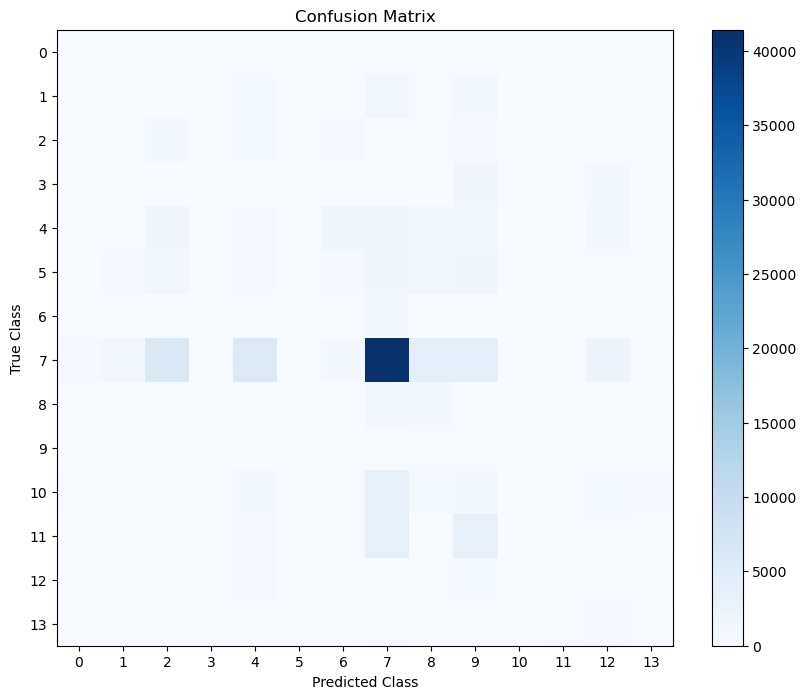

In [13]:
# Make predictions on test data
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predicted probabilities to class labels

# Get actual labels of test data
y_true = test_generator.classes

# Create confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(confusion_mtx, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(14))
plt.yticks(np.arange(14))
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()

# 